In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pandas import Series, DataFrame
import nltk

import spacy
import string

from gensim import corpora, models, similarities

import tensorflow as tf
import tensorflow_hub as hub

from gensim.models import Word2Vec

C:\Users\manzh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\manzh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\manzh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\manzh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [3]:
df = pd.read_csv('C:/data/CS/SA/threshold4_balanced_training_set.csv', usecols=['CONTENT','sentiment'])
df.head(10)
df['label']=df['sentiment']
df['label'].value_counts()

positive    1269
neutral     1269
negative    1269
Name: label, dtype: int64

In [4]:
for i, item in enumerate (df['label']):
  if item=='positive':
    df['label'][i]=2
  if item=='neutral':
    df['label'][i]=1
  if item=='negative':
    df['label'][i]=0
df['label'].value_counts()

2    1269
1    1269
0    1269
Name: label, dtype: int64

In [5]:
tdf = pd.read_csv('C:/data/CS/SA/test.csv')

In [6]:
x = df['CONTENT']
y = df['label']
x_test=tdf['CONTENT']
y_test=tdf['label']


In [7]:
corpus=df['CONTENT'].append(tdf['CONTENT'])
len(corpus)

4177

In [17]:
tendf = pd.read_csv('C:/data/CS/SA/10news_11132019_mannual_labelled.csv')
x_ten=tendf['CONTENT']
y_ten=tendf['label']

In [8]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.2, random_state=SEED)
#print (x_train)
y_train=y_train.astype('int')
y_validation=y_validation.astype('int')
y_test=y_test.astype('int')

In [10]:
!pip install TextBlob

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\manzh\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\manzh\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\manzh\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\manzh\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\manzh\anaconda3\lib\site-packages\pip\_inter

In [11]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [14]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.33:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [15]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 3), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [16]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (cvec)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1,3))

RESULT FOR TRIGRAM WITH STOP WORDS (cvec)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


null accuracy: 34.78%
accuracy score: 58.01%
model is 23.23% more accurate than null accuracy
train and test time: 41.01s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 34.78%
accuracy score: 57.87%
model is 23.10% more accurate than null accuracy
train and test time: 40.29s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 34.78%
accuracy score: 60.24%
model is 25.46% more accurate than null accuracy
train and test time: 48.84s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 34.78%
accuracy score: 59.84%
model is 25.07% more accurate than null accuracy
train and test time: 54.84s
--------------------------------------------------------------------------------
Validation result for 50000 features
null accuracy: 34.78%
accuracy score: 61

In [18]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])

#Chi2 Feature Selection
In Sklearn, there are three methods you can use for feature selection with sparse matrices such as Tfidf vectors or count vectors, namely, chi2, mutual_info_regression, mutual_info_classif. They will deal with the data without making it dense. 
The Chi-squared statistic measures the lack of independence between a feature (in this case, one term within a news article) and class (whether the articles are positive, neutral or negative).

In [19]:
from sklearn.feature_selection import chi2
cvec = CountVectorizer(max_features=100001,ngram_range=(1, 3))
chi2_m=cvec.fit(corpus)
x_train_cvec = chi2_m.transform(x_train)
x_validation_cvec = chi2_m.transform(x_validation)
x_test_cvec = chi2_m.transform(x_test)
x_ten_cvec = chi2_m.transform(x_ten)
chi2score = chi2(x_train_cvec, y_train)[0]


Text(0.5,0,'$\\chi^2$')

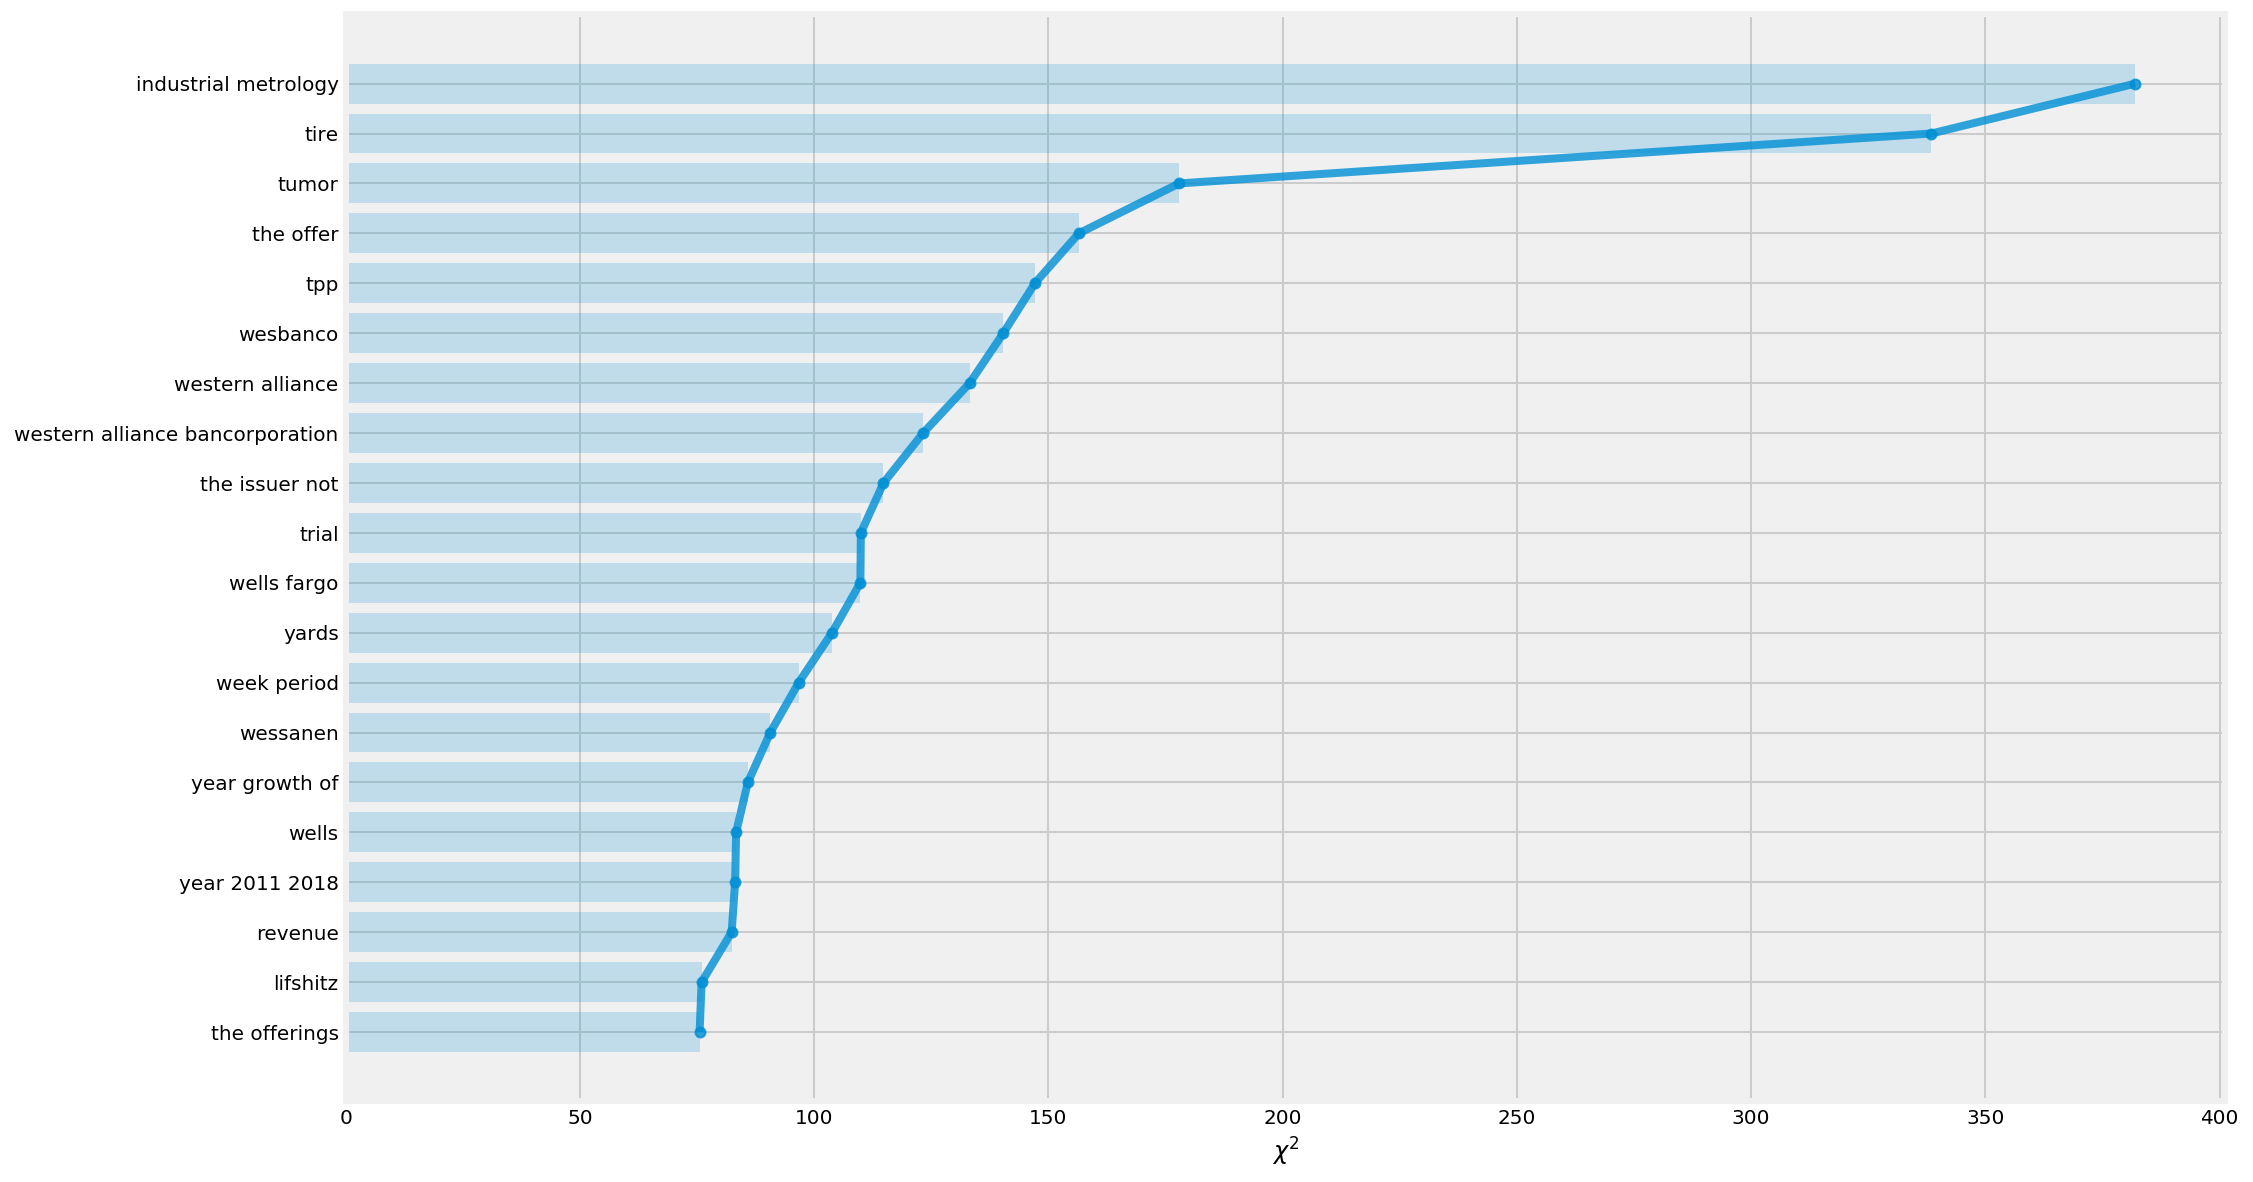

In [21]:
plt.figure(figsize=(15,10))
wscores = zip(cvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

The most useful feature selected by chi2 is the word "industrial metrology".  If you consider how chi2 is calculated, it will not only score highly on terms predictive of positive class but also score highly on terms predictive of negative and neutral class.

Since now we have an idea of how the chi2 feature selection works, let's reduce the dimensions to different number of features, and also check the accuracy on the validation set.

In [22]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
ch2_result = []
for n in np.arange(10000,100001,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_cvec, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_cvec)
    x_test_chi2_selected = ch2.transform(x_test_cvec)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print ("chi2 feature selection evaluation calculated for {} features".format(n))
    print (score)

C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 10000 features
0.5577427821522309


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 20000 features
0.594488188976378


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 30000 features
0.610236220472441


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 40000 features
0.5958005249343832


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 50000 features
0.6062992125984252


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 60000 features
0.594488188976378


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 70000 features
0.6076115485564304


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 80000 features
0.5971128608923885


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


chi2 feature selection evaluation calculated for 90000 features
0.610236220472441


C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


chi2 feature selection evaluation calculated for 100000 features
0.6062992125984252


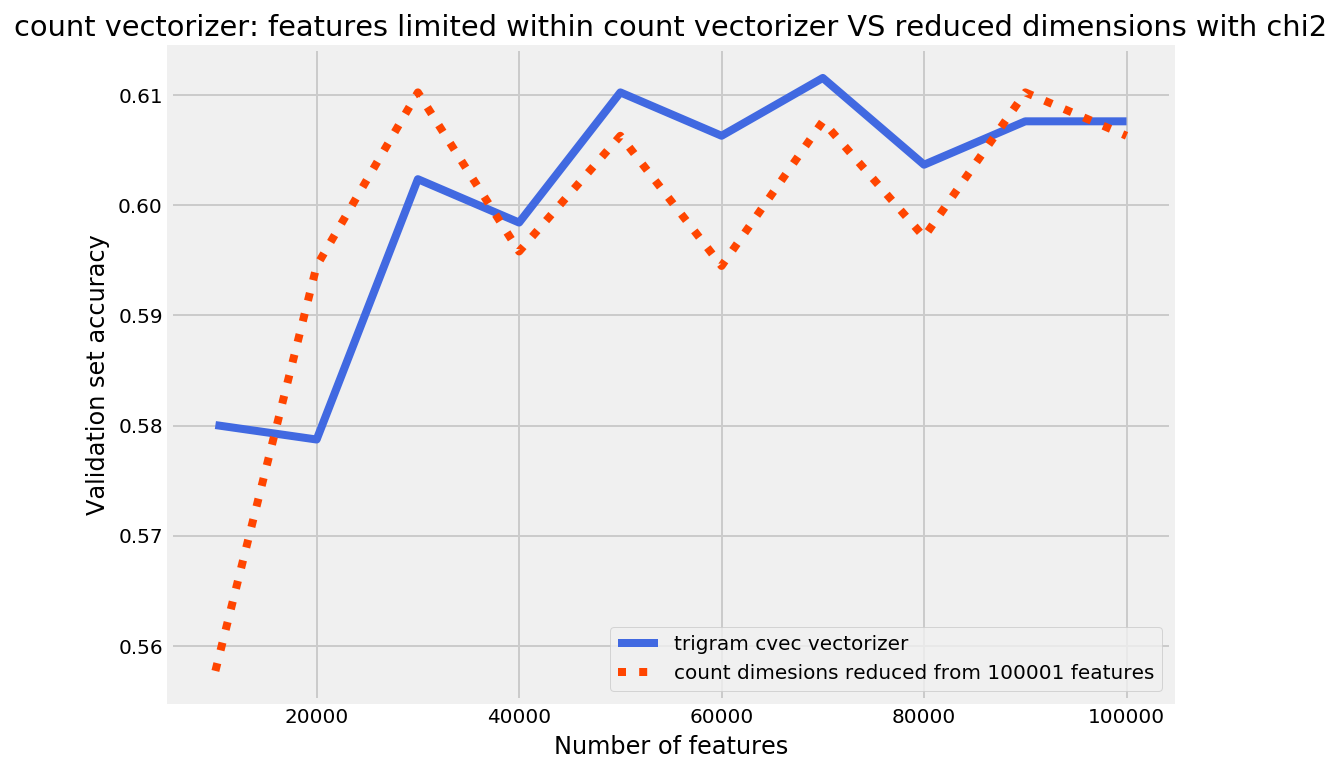

In [23]:
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram cvec vectorizer',color='royalblue')
plt.plot(np.arange(10000,100001,10000), ch2_result,label='count dimesions reduced from 100001 features',linestyle=':', color='orangered')

plt.title("count vectorizer: features limited within count vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

On the above graph, the red dotted line is validation set accuracy from dimensionality reduction, and the blue line is the result of limiting the number of features in the first place when fitting count vectorizer. We can see that reducing the dimensions from bigger features in the first place yields better result than limiting the number of features with count vectorizer. Then with the increment of the number of features, the dimension reduction loses its edge in the accuracy. This is not a general statement, but what I have found within this particular setting. It can be also seen from the graph that the best accuracy is produced by chi2 when the feature number is limited to 30000. 

In [25]:
ch2 = SelectKBest(chi2, k=30000)
x_train_chi2_selected = ch2.fit_transform(x_train_cvec, y_train)
x_validation_chi2_selected = ch2.transform(x_validation_cvec)
x_test_chi2_selected = ch2.transform(x_test_cvec)
x_ten_chi2_selected = ch2.transform(x_ten_cvec)
clf = LogisticRegression()
clf.fit(x_train_chi2_selected, y_train)
score = clf.score(x_validation_chi2_selected, y_validation)
print (score)

C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\manzh\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.610236220472441


In [26]:
import pickle
pkl_filename = "cs_sa_chi2_pickle_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(clf, file)

In [29]:
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)